In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, f_oneway

conn = sqlite3.connect("C:/projects/football/database.sqlite")

tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)
#print(tables)

In [2]:
matches = pd.read_sql("SELECT * from Match LIMIT 5", conn)
#matches.head()

In [3]:
#checking values for null
checking_values = pd.read_sql("SELECT * from Match", conn)
missing_values = checking_values.isnull().sum()
#print(missing_values)

In [4]:
#print top 5 leagues by most goals
query = """
SELECT l.name AS league,
    SUM(m.home_team_goal + m.away_team_goal) AS total_goals
FROM Match m 
JOIN League l on m.league_id = l.id
GROUP BY l.name
ORDER BY total_goals DESC
LIMIT 5
"""

league_goals = pd.read_sql(query, conn)
#print(league_goals)

C:\Users\Администратор\AppData\Local\Temp\ipykernel_1476\802238128.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="total_goals", y="league", hue=None, data=league_goals, palette='viridis')


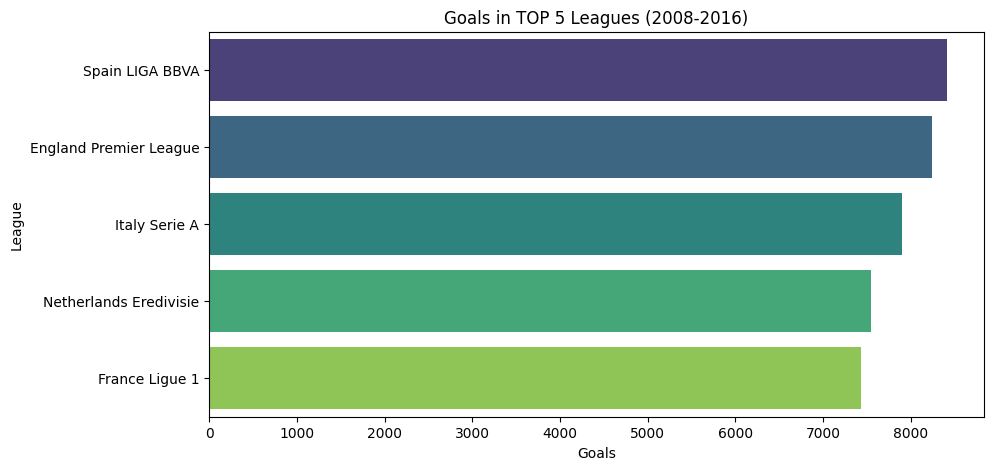

In [5]:
#visualization
plt.figure(figsize=(10,5))
sns.barplot(x="total_goals", y="league", hue=None, data=league_goals, palette='viridis')
plt.title("Goals in TOP 5 Leagues (2008-2016)")
plt.xlabel("Goals")
plt.ylabel("League")
plt.show()

In [6]:
#TOP 10 teams by numbers of wins
query = """
SELECT t.team_long_name AS team,
    SUM(CASE WHEN m.home_team_api_id = t.team_api_id AND m.home_team_goal > m.away_team_goal THEN 1 ELSE 0 END) AS home_wins,
    SUM(CASE WHEN m.away_team_api_id = t.team_api_id AND m.away_team_goal > m.home_team_goal THEN 1 ELSE 0 END) AS away_wins
FROM Team t
JOIN Match m ON t.team_api_id = m.home_team_api_id OR t.team_api_id = m.away_team_api_id
GROUP BY t.team_long_name
ORDER BY home_wins + away_wins DESC
LIMIT 10
"""

team_stats = pd.read_sql(query, conn)
#print(team_stats)

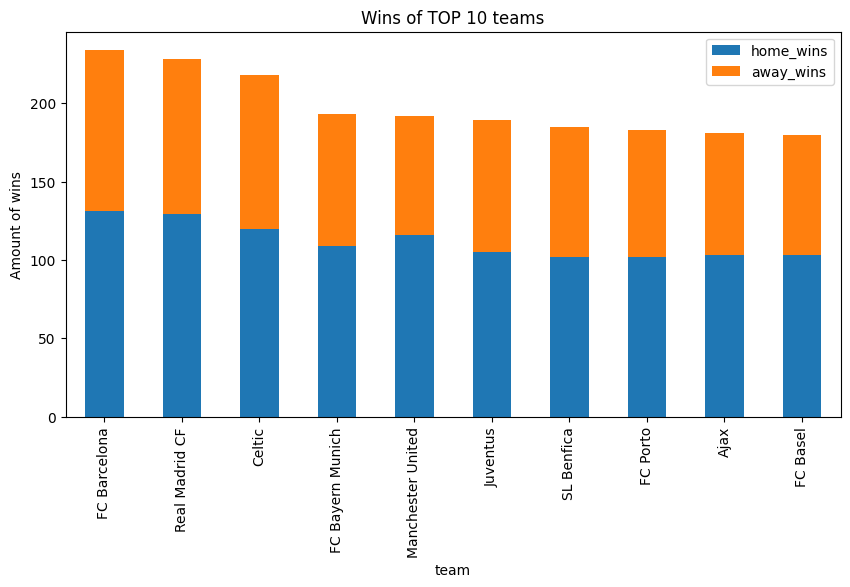

In [7]:
#visualization
team_stats.set_index('team').plot(kind='bar', stacked=True, figsize=(10,5))
plt.title("Wins of TOP 10 teams")
plt.ylabel("Amount of wins")
plt.show()

In [8]:
#variables for tables
teams = pd.read_sql("SELECT team_api_id, team_long_name FROM Team", conn)
matches = pd.read_sql("SELECT home_team_api_id, away_team_api_id, home_team_goal, away_team_goal FROM Match", conn)
team_attrs = pd.read_sql("SELECT team_api_id, defencePressure, defenceAggression, buildUpPlaySpeed, buildUpPlayPassing FROM Team_Attributes", conn)

In [9]:
# home wins
home_wins = matches[matches['home_team_goal'] > matches['away_team_goal']]
home_win_counts = home_wins['home_team_api_id'].value_counts().reset_index()
home_win_counts.columns = ['team_api_id', 'home_wins']

# away wins
away_wins = matches[matches['away_team_goal'] > matches['home_team_goal']]
away_win_counts = away_wins['away_team_api_id'].value_counts().reset_index()
away_win_counts.columns = ['team_api_id', 'away_wins']

# total wins
total_wins = pd.merge(home_win_counts, away_win_counts, on='team_api_id', how='outer').fillna(0)
total_wins['total_wins'] = total_wins['home_wins'] + total_wins['away_wins']

# team names
team_stats = pd.merge(total_wins, teams, on='team_api_id')

In [10]:
# AVG defense indicators
defence_stats = team_attrs.groupby('team_api_id').mean().reset_index()

# merge with wins
team_stats = pd.merge(team_stats, defence_stats, on='team_api_id')

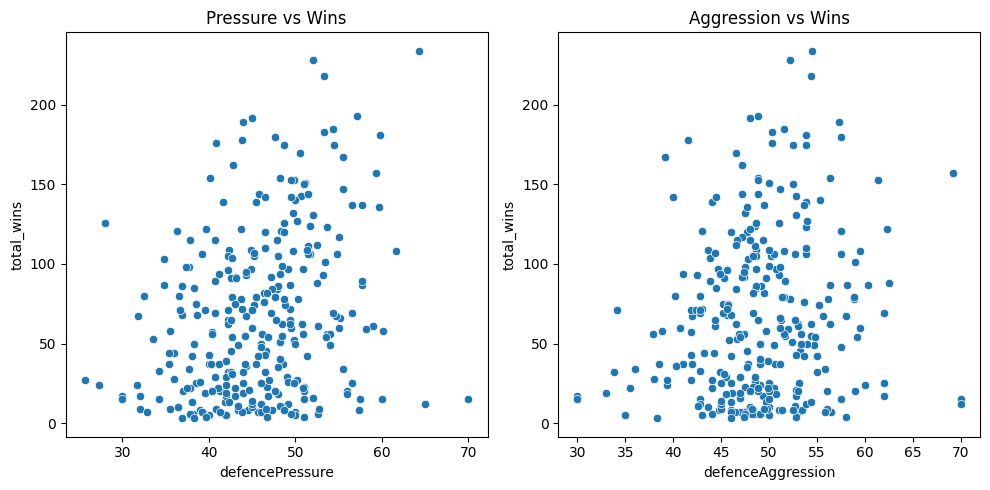

In [11]:
# correalation
correlation = team_stats[['total_wins', 'defencePressure', 'defenceAggression']].corr()
#print(correlation)

# visualization
plt.figure(figsize=(10,5))

# graph 1: defencePressure vs wins
plt.subplot(1, 2, 1)
sns.scatterplot(x='defencePressure', y='total_wins', data=team_stats)
plt.title('Pressure vs Wins')

# graph 2: defenceAggression vs wins
plt.subplot(1, 2, 2)
sns.scatterplot(x='defenceAggression', y='total_wins', data=team_stats)
plt.title('Aggression vs Wins')

plt.tight_layout()
plt.show()

C:\Users\Администратор\AppData\Local\Temp\ipykernel_1476\3365107129.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='defence_score', y='team_long_name', data=top_defence_teams, palette='rocket')


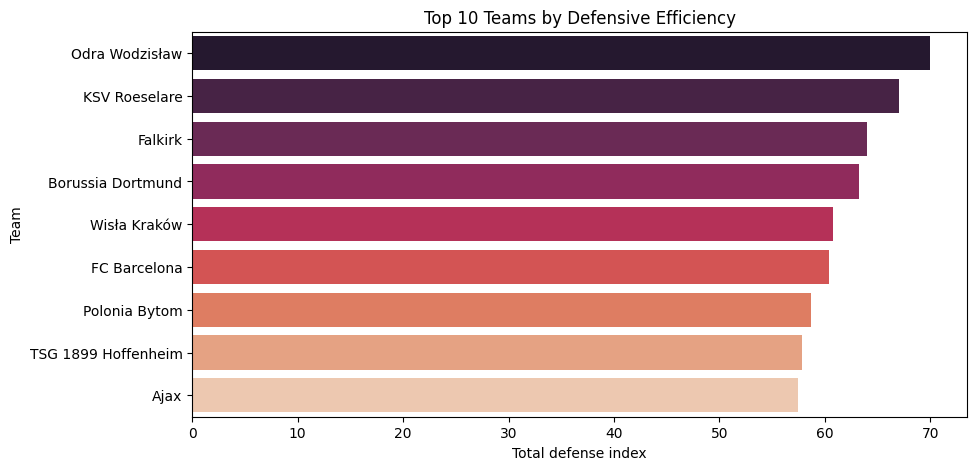

In [12]:
# rating
team_stats['defence_score'] = team_stats['defencePressure'] * 0.6 + team_stats['defenceAggression'] * 0.4
top_defence_teams = team_stats.sort_values('defence_score', ascending=False).head(10)

# visualization
plt.figure(figsize=(10, 5))
sns.barplot(x='defence_score', y='team_long_name', data=top_defence_teams, palette='rocket')
plt.title('Top 10 Teams by Defensive Efficiency')
plt.xlabel('Total defense index')
plt.ylabel('Team')
plt.show()

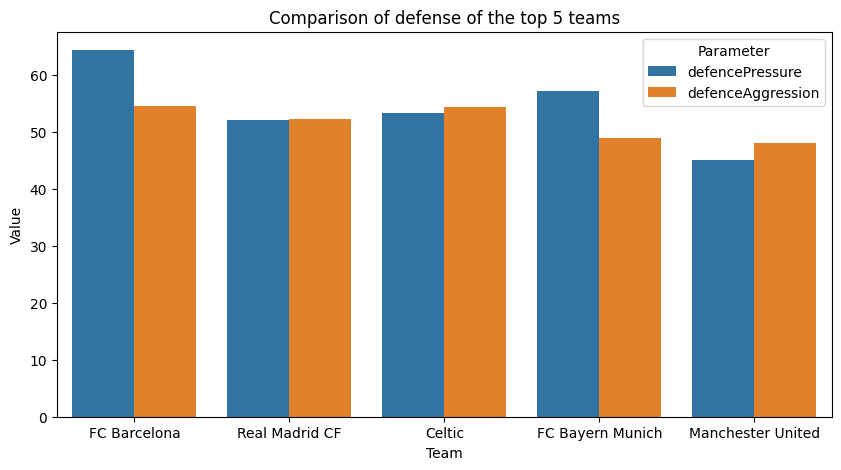

In [13]:
top_teams = team_stats.sort_values('total_wins', ascending=False).head(5)

# Preparing data for the graph
melted = top_teams.melt(id_vars='team_long_name', 
                        value_vars=['defencePressure', 'defenceAggression'], 
                        var_name='parameter', 
                        value_name='value')

# graph
plt.figure(figsize=(10, 5))
sns.barplot(x='team_long_name', y='value', hue='parameter', data=melted)
plt.title('Comparison of defense of the top 5 teams')
plt.xlabel('Team')
plt.ylabel('Value')
plt.legend(title='Parameter')
plt.show()

In [14]:
# home goals
home_goals = matches.groupby('home_team_api_id')['home_team_goal'].sum().reset_index()
home_goals.columns = ['team_api_id', 'home_goals']

# away goals
away_goals = matches.groupby('away_team_api_id')['away_team_goal'].sum().reset_index()
away_goals.columns = ['team_api_id', 'away_goals']

# total goals
total_goals = pd.merge(home_goals, away_goals, on='team_api_id', how='outer').fillna(0)
total_goals['total_goals'] = total_goals['home_goals'] + total_goals['away_goals']

# team names
team_stats = pd.merge(total_goals, teams, on='team_api_id')

In [15]:
# AVG attack indicators
attack_stats = team_attrs.groupby('team_api_id')[['buildUpPlaySpeed', 'buildUpPlayPassing']].mean().reset_index()

# merge with goals
team_stats = pd.merge(team_stats, attack_stats, on='team_api_id')

# AVG goals per match
team_stats['avg_goals_per_match'] = team_stats['total_goals'] / (len(matches) * 2)

C:\Users\Администратор\AppData\Local\Temp\ipykernel_1476\3564615434.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  passing_goals = team_stats.groupby('buildUpPlayPassingClass')['total_goals'].mean().reset_index()


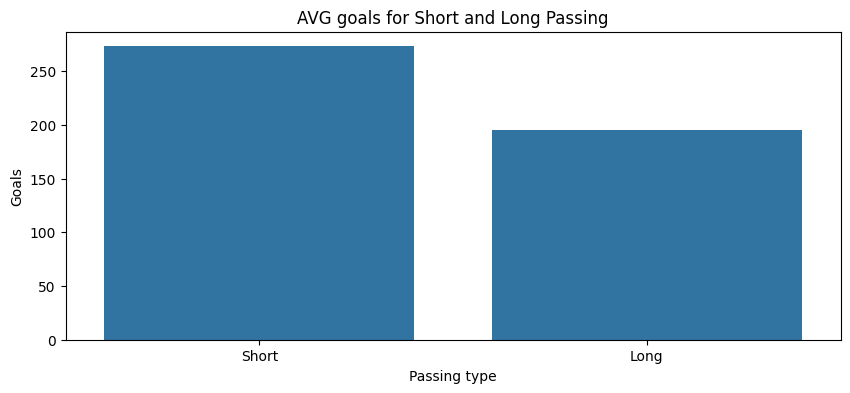

In [16]:
# converting to text format
team_stats['buildUpPlayPassingClass'] = pd.cut(team_stats['buildUpPlayPassing'], 
                                              bins=[0, 50, 100], 
                                              labels=['Short', 'Long'])

# AVG goals for each type
passing_goals = team_stats.groupby('buildUpPlayPassingClass')['total_goals'].mean().reset_index()

# graph
plt.figure(figsize=(10, 4))
sns.barplot(x='buildUpPlayPassingClass', y='total_goals', data=passing_goals)
plt.title('AVG goals for Short and Long Passing')
plt.xlabel('Passing type')
plt.ylabel('Goals')
plt.show()

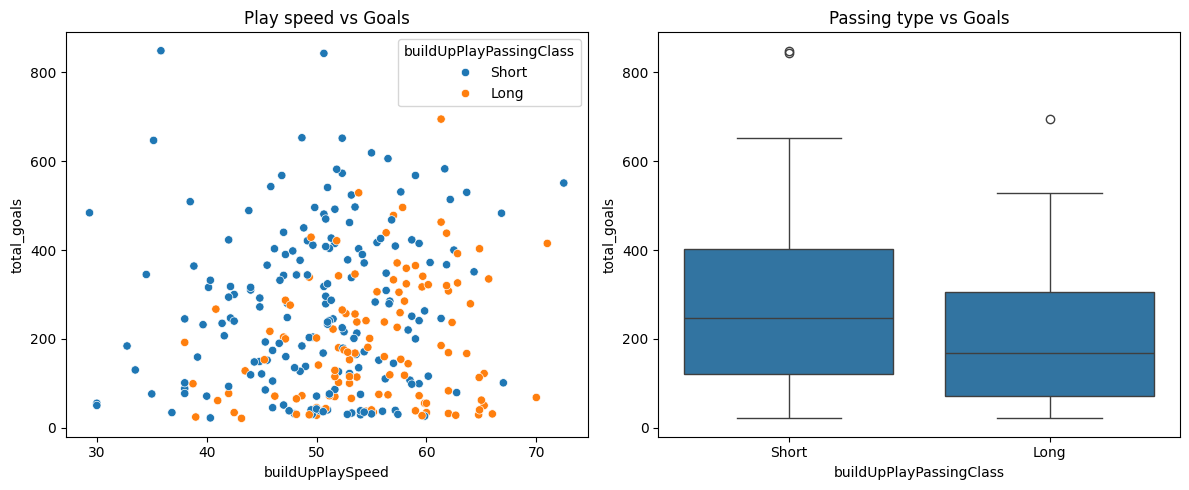

In [17]:
# creating a column based on the numeric values of buildUpPlayPassing
team_stats['buildUpPlayPassingClass'] = pd.cut(
    team_stats['buildUpPlayPassing'],
    bins=[0, 50, 100],
    labels=['Short', 'Long']
)

# creating graph
plt.figure(figsize=(12, 5))

# graph 1: buildUpPlaySpeed vs Goals
plt.subplot(1, 2, 1)
sns.scatterplot(x='buildUpPlaySpeed', y='total_goals', data=team_stats, hue='buildUpPlayPassingClass')
plt.title('Play speed vs Goals')

# graph 2: buildUpPlayPassingClass vs Goals
plt.subplot(1, 2, 2)
sns.boxplot(
    x='buildUpPlayPassingClass', 
    y='total_goals', 
    data=team_stats,
    order=['Short', 'Long'] 
)
plt.title('Passing type vs Goals')

plt.tight_layout()
plt.show()

C:\Users\Администратор\AppData\Local\Temp\ipykernel_1476\1912672032.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='team_long_name', y='buildUpPlaySpeed', data=top_speed_teams, palette='viridis')


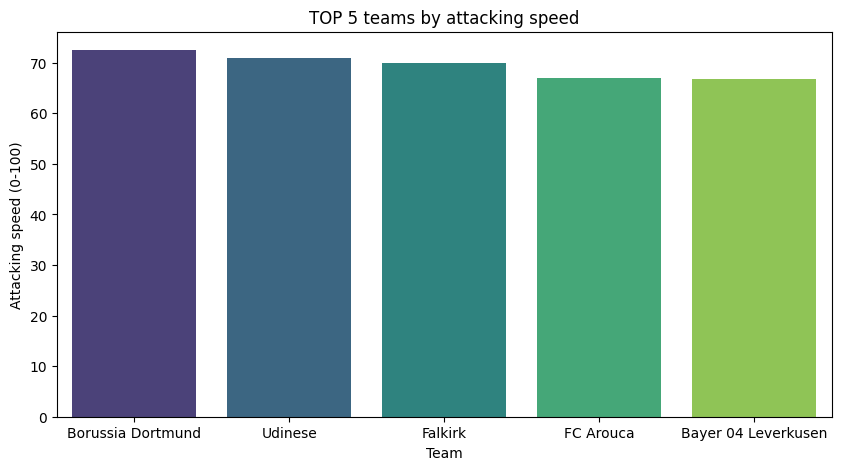

In [18]:
top_speed_teams = team_stats.sort_values('buildUpPlaySpeed', ascending=False).head(5)

# visualization
plt.figure(figsize=(10, 5))
sns.barplot(x='team_long_name', y='buildUpPlaySpeed', data=top_speed_teams, palette='viridis')
plt.title('TOP 5 teams by attacking speed')
plt.xlabel('Team')
plt.ylabel('Attacking speed (0-100)')
plt.show()

In [19]:
from scipy.stats import ttest_ind

# divide the data into two groups
high_speed = team_stats[team_stats['buildUpPlaySpeed'] >= 70]['total_goals']
low_speed = team_stats[team_stats['buildUpPlaySpeed'] < 70]['total_goals']

# conduct t-test
t_stat, p_value = ttest_ind(high_speed, low_speed)

print(f"t-test results: p-value = {p_value:.3f}")
if p_value < 0.05:
    print("The difference is statistically significant. (p < 0.05)")
else:
    print("The difference is insignificant")

t-test results: p-value = 0.299
The difference is insignificant


In [20]:
from scipy.stats import f_oneway

# group data by categories
short_passing = team_stats[team_stats['buildUpPlayPassingClass'] == 'Short']['total_goals']
long_passing = team_stats[team_stats['buildUpPlayPassingClass'] == 'Long']['total_goals']

# conduct ANOVA
f_stat, p_value = f_oneway(short_passing, long_passing)

print(f"ANOVA results: p-value = {p_value:.3f}")

ANOVA results: p-value = 0.000
